## Imports


In [2]:
import pandas as pd
import numpy as np
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, Dense, Concatenate, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Pre-Processing

In [19]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

def cleaned_options(option_type, df):
    # Convert Unix timestamps to datetime
    df['[QUOTE_DATETIME]'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
    df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

    # Load underlying price data for volatility computation
    underlying_prices = df[['[QUOTE_DATETIME]', '[UNDERLYING_LAST]']].drop_duplicates().set_index('[QUOTE_DATETIME]').sort_index()

    # Function to compute historical volatility
    def historical_volatility(series, window=20):
        return np.sqrt(252) * series.pct_change().rolling(window=window).std()

    # Compute 20-day historical volatility
    underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
    underlying_prices.dropna(inplace=True)

    # Merge historical volatility back into main dataframe
    df = df.merge(underlying_prices[['hist_vol_20d']], left_on='[QUOTE_DATETIME]', right_index=True, how='inner')

    # Columns to numeric conversion: choose columns based on option type
    if option_type == 'call':
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                        '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
    else:
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                        '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate mid-price based on option type
    if option_type == 'call':
        df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
    else:
        df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

    # Drop rows with missing essential data (dynamically chosen based on option type)
    essential_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
    if option_type == 'call':
        essential_cols.append('CALL_EQUI_PRICE')
    else:
        essential_cols.append('PUT_EQUI_PRICE')
    df.dropna(subset=essential_cols, inplace=True)

    # Prepare option data based on the option type
    if option_type == 'call':
        option_cols = ['[STRIKE]', '[C_BID]', '[C_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'CALL_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']
    else:
        option_cols = ['[STRIKE]', '[P_BID]', '[P_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'PUT_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']

    option_df = df[option_cols].copy()
    option_df.columns = col_rename

    # Normalize strike price and compute time to expiry in years
    option_df['strike_price'] = option_df['strike_price'] / 1000
    option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
    option_df.drop('days_to_expiry', axis=1, inplace=True)
    return option_df

calls_df = cleaned_options("call", df)
puts_df = cleaned_options("put", df)
print(calls_df.columns.tolist())

['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'hist_volatility', 'equilibrium_price', 'time_to_expiry']


## Hyperparameters

In [36]:
N_TIMESTEPS = 20
NUM_FEATURES = 7
HIDDEN_LAYERS = 2
BATCH_SIZE = 1024
EPOCHS = 60

## Rolling Window Logic

In [20]:
def build_rolling_sequences(
    df,
    date_col="date",
    input_cols=["underlying_price", "strike_price", "hist_volatility"],
    bid_col="best_bid",
    ask_col="best_ask",
    use_midpoint_target=True,     # If True, label = (best_bid + best_ask)/2
    target_col="equilibrium_price", 
    n_timesteps=20,
    train_ratio=0.8
):
    """
    1) Sort df by 'date_col'.
    2) For each row i from n_timesteps..end, builds a window [i-n_timesteps : i-1]
       of the columns in 'input_cols'.
    3) By default, label is midpoint of best_bid & best_ask at row i; 
       or specify 'target_col' if you prefer a single column as the label.
    4) Returns X_train, X_test, y_train, y_test with time-based splitting.
    
    X shape: (num_samples, n_timesteps, len(input_cols))
    y shape: (num_samples,)
    """
    # Sort by date to ensure chronological order
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    n_rows = len(df_sorted)
    
    X_seq = []
    y_seq = []
    
    # Build rolling windows
    for i in range(n_timesteps, n_rows):
        # Collect the last n_timesteps from each of the 'input_cols'
        window_data = []
        for col in input_cols:
            col_window = df_sorted.loc[i - n_timesteps : i - 1, col].values
            window_data.append(col_window)
        
        # Stack horizontally so shape is (n_timesteps, num_features)
        window_data = np.column_stack(window_data)
        
        # Create the label (either midpoint or a specific column)
        if use_midpoint_target:
            label_val = (
                df_sorted.loc[i, bid_col] +
                df_sorted.loc[i, ask_col]
            ) / 2
        else:
            label_val = df_sorted.loc[i, target_col]
        
        X_seq.append(window_data)
        y_seq.append(label_val)
    
    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # (samples, n_timesteps, num_features)
    y_seq = np.array(y_seq)  # (samples,)

    # Time-based train-test split
    n_samples = len(X_seq)
    n_train = int(n_samples * train_ratio)
    
    X_train, X_test = X_seq[:n_train], X_seq[n_train:]
    y_train, y_test = y_seq[:n_train], y_seq[n_train:]
    
    print("Total samples:", n_samples)
    print("Train samples:", n_train, "Test samples:", n_samples - n_train)
    print("X shape:", X_seq.shape, "y shape:", y_seq.shape)
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_test :", X_test.shape,  "y_test :", y_test.shape)
    
    return X_train, X_test, y_train, y_test

## Prepare Test Split

In [21]:
# For CALLS:
X_call_train, X_call_test, y_call_train, y_call_test = build_rolling_sequences(
    df=calls_df,
    date_col="date",
    input_cols=["underlying_price", "strike_price", "hist_volatility"],
    bid_col="best_bid",
    ask_col="best_ask",
    use_midpoint_target=True,    # True => label = midpoint
    target_col="equilibrium_price",
    n_timesteps=N_TIMESTEPS,
    train_ratio=0.8
)

# For PUTS (same idea):
X_put_train, X_put_test, y_put_train, y_put_test = build_rolling_sequences(
    df=puts_df,
    date_col="date",
    input_cols=["underlying_price", "strike_price", "hist_volatility"],
    bid_col="best_bid",
    ask_col="best_ask",
    use_midpoint_target=True,
    target_col="equilibrium_price",
    n_timesteps=N_TIMESTEPS,
    train_ratio=0.8
)

Total samples: 1549508
Train samples: 1239606 Test samples: 309902
X shape: (1549508, 20, 3) y shape: (1549508,)
X_train: (1239606, 20, 3) y_train: (1239606,)
X_test : (309902, 20, 3) y_test : (309902,)
Total samples: 1549500
Train samples: 1239600 Test samples: 309900
X shape: (1549500, 20, 3) y shape: (1549500,)
X_train: (1239600, 20, 3) y_train: (1239600,)
X_test : (309900, 20, 3) y_test : (309900,)


## LSTM Model

In [22]:
def create_lstm_model(n_timesteps, n_features, lstm_units=32, dense_layers=2, dense_units=64):
    """
    Builds a basic LSTM model that outputs a single price prediction.
    """
    inputs = Input(shape=(n_timesteps, n_features), name="lstm_input")
    
    # LSTM stack (you can add more layers as needed)
    x = LSTM(lstm_units, return_sequences=True)(inputs)
    x = LSTM(lstm_units, return_sequences=False)(x)  # final LSTM layer
    
    # Dense feedforward layers
    for _ in range(dense_layers):
        x = Dense(dense_units)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    
    # Output layer for a single price
    outputs = Dense(1, activation='linear', name="price_output")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

## Training for Calls

In [ ]:
n_timesteps = X_call_train.shape[1]
n_features = X_call_train.shape[2]

call_model = create_lstm_model(n_timesteps=n_timesteps, n_features=n_features)
call_model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

call_history = call_model.fit(
    X_call_train,
    y_call_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.01,
    callbacks=[TensorBoard(log_dir='./logs')],
    verbose=1
)

call_model.save('call-lstm-v1.h5')

Epoch 1/5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 3528.3953 - val_loss: 3041.3716
Epoch 2/5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 2717.5464 - val_loss: 1453.0043
Epoch 3/5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 2099.1465 - val_loss: 3073.0771
Epoch 4/5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 1563.4468 - val_loss: 880.8939
Epoch 5/5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 1188.2710 - val_loss: 784.8933


## Training for Puts

In [ ]:
n_timesteps = X_put_train.shape[1]
n_features = X_put_train.shape[2]

put_model = create_lstm_model(n_timesteps=n_timesteps, n_features=n_features)
put_model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

put_history = put_model.fit(
    X_put_train,
    y_put_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.01,
    callbacks=[TensorBoard(log_dir='./logs')],
    verbose=1
)

put_model.save('put-lstm-v1.h5')

## Test Models

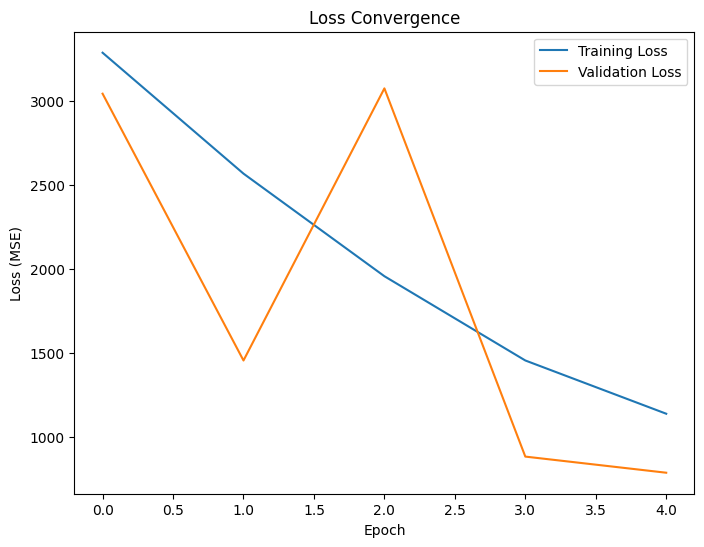

In [ ]:
def plot_loss_convergence(history):
    """
    Plots training vs validation loss over epochs.
    """
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()

plot_loss_convergence(call_history)
plot_loss_convergence(put_history)